# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d100/2f0bb04162655f0cba429b865292f31482e817e0b3ee9da0f40185d7.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Shepherds Bush, Hammersmith and Fulham, United Kingdom**, and the stations the data comes from are shown on the map below.

In [1]:
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(100,'2f0bb04162655f0cba429b865292f31482e817e0b3ee9da0f40185d7')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib notebook

df = pd.read_csv('data/C2A2_data/BinnedCsvs_d100/2f0bb04162655f0cba429b865292f31482e817e0b3ee9da0f40185d7.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67648 entries, 0 to 67647
Data columns (total 4 columns):
ID            67648 non-null object
Date          67648 non-null object
Element       67648 non-null object
Data_Value    67648 non-null int64
dtypes: int64(1), object(3)
memory usage: 2.6+ MB


In [3]:
# Remove leap days i.e. feb 29th

df = df[~df['Date'].str.contains('02-29')]

# Convert date to datetime

df['Date'] = pd.to_datetime(df['Date'])

# Convert value to degrees celcius

df['Data_Value'] = df['Data_Value'].apply(lambda x: x * 0.1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67614 entries, 0 to 67647
Data columns (total 4 columns):
ID            67614 non-null object
Date          67614 non-null datetime64[ns]
Element       67614 non-null object
Data_Value    67614 non-null float64
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.6+ MB


In [4]:
# Filter datasets for 2005-2014

years_filter = (df['Date'].dt.year >= 2005) & (df['Date'].dt.year <= 2014)

period_df = df[years_filter]

In [5]:
# Create a dataframe for record lows

min_df = period_df[period_df['Element'] == 'TMIN']

min_df = (min_df
          .groupby([period_df['Date'].dt.month, period_df['Date'].dt.day])
          .agg({'Data_Value': np.min}))

In [6]:
# Create a dataframe for record highs

max_df = period_df[period_df['Element'] == 'TMAX']

max_df = (max_df
          .groupby([period_df['Date'].dt.month, period_df['Date'].dt.day])
          .agg({'Data_Value': np.max}))

In [7]:
record_temp_df = (pd
           .merge(min_df, max_df, left_index=True, right_index=True)
           .rename(columns={'Data_Value_x': 'MIN', 'Data_Value_y': 'MAX'}))

record_temp_df.head()

MIN   MAX
Date Date           
1    1    -3.4  13.0
     2    -4.3  11.3
     3    -6.9  12.6
     4    -7.6  11.7
     5    -8.0  12.2

In [8]:
# Create datetime index for plotting

import datetime

# Using the MultiIndex, constructing datetime for non-leap year

new_index = [pd.to_datetime('2009-{}-{}'.format(date[0], date[1])) for date in record_temp_df.index]

record_temp_df['new_index'] = new_index

record_temp_df = record_temp_df.reset_index(drop=True).set_index('new_index')

record_temp_df.head()

,MIN,MAX
new_index,,
2009-01-01,-3.4,13.0
2009-01-02,-4.3,11.3
2009-01-03,-6.9,12.6
2009-01-04,-7.6,11.7
2009-01-05,-8.0,12.2


In [9]:
# Extract dataset for 2015

latest_df = df[df['Date'].dt.year == 2015]

In [10]:
# Create a dataframe for record lows in 2015

latest_min_df = latest_df[latest_df['Element'] == 'TMIN']

latest_min_df = (latest_min_df
                 .groupby([latest_df['Date'].dt.month, latest_df['Date'].dt.day])
                 .agg({'Data_Value': np.min}))

In [11]:
# Create a dataframe for record highs in 2015

latest_max_df = latest_df[latest_df['Element'] == 'TMAX']

latest_max_df = (latest_max_df
                 .groupby([latest_df['Date'].dt.month, latest_df['Date'].dt.day])
                 .agg({'Data_Value': np.max}))

In [12]:
# Merge lows & highs and convert index to datetime

latest_temp_df = (pd
                  .merge(latest_min_df, latest_max_df, left_index=True, right_index=True)
                  .rename(columns={'Data_Value_x': '2015_min', 'Data_Value_y': '2015_max'}))

latest_temp_df['new_index'] = new_index

latest_temp_df = latest_temp_df.reset_index(drop=True).set_index('new_index')

latest_temp_df.head()

,2015_min,2015_max
new_index,,
2009-01-01,2.9,10.8
2009-01-02,5.9,11.4
2009-01-03,0.9,8.2
2009-01-04,-1.4,8.6
2009-01-05,-1.1,10.0


In [13]:
# Merge record_temp_df and latest_temp_df

merged_df = pd.merge(record_temp_df, 
                     latest_temp_df, 
                     left_index=True, 
                     right_index=True)

merged_df.head()

,MIN,MAX,2015_min,2015_max
new_index,,,,
2009-01-01,-3.4,13.0,2.9,10.8
2009-01-02,-4.3,11.3,5.9,11.4
2009-01-03,-6.9,12.6,0.9,8.2
2009-01-04,-7.6,11.7,-1.4,8.6
2009-01-05,-8.0,12.2,-1.1,10.0


In [14]:
# for 2015 columns, only keep if it's lower (for min) or higher (for max) than the record low/high

def foo(entry):
    if entry['2015_min'] >= entry['MIN']:
        entry['2015_min'] = None
    
    if entry['2015_max'] <= entry['MAX']:
        entry['2015_max'] = None

    return entry    

merged_df = merged_df.apply(foo, axis=1)

merged_df.head()

,MIN,MAX,2015_min,2015_max
new_index,,,,
2009-01-01,-3.4,13.0,NaN,NaN
2009-01-02,-4.3,11.3,NaN,11.4
2009-01-03,-6.9,12.6,NaN,NaN
2009-01-04,-7.6,11.7,NaN,NaN
2009-01-05,-8.0,12.2,NaN,NaN


<IPython.core.display.Javascript object>


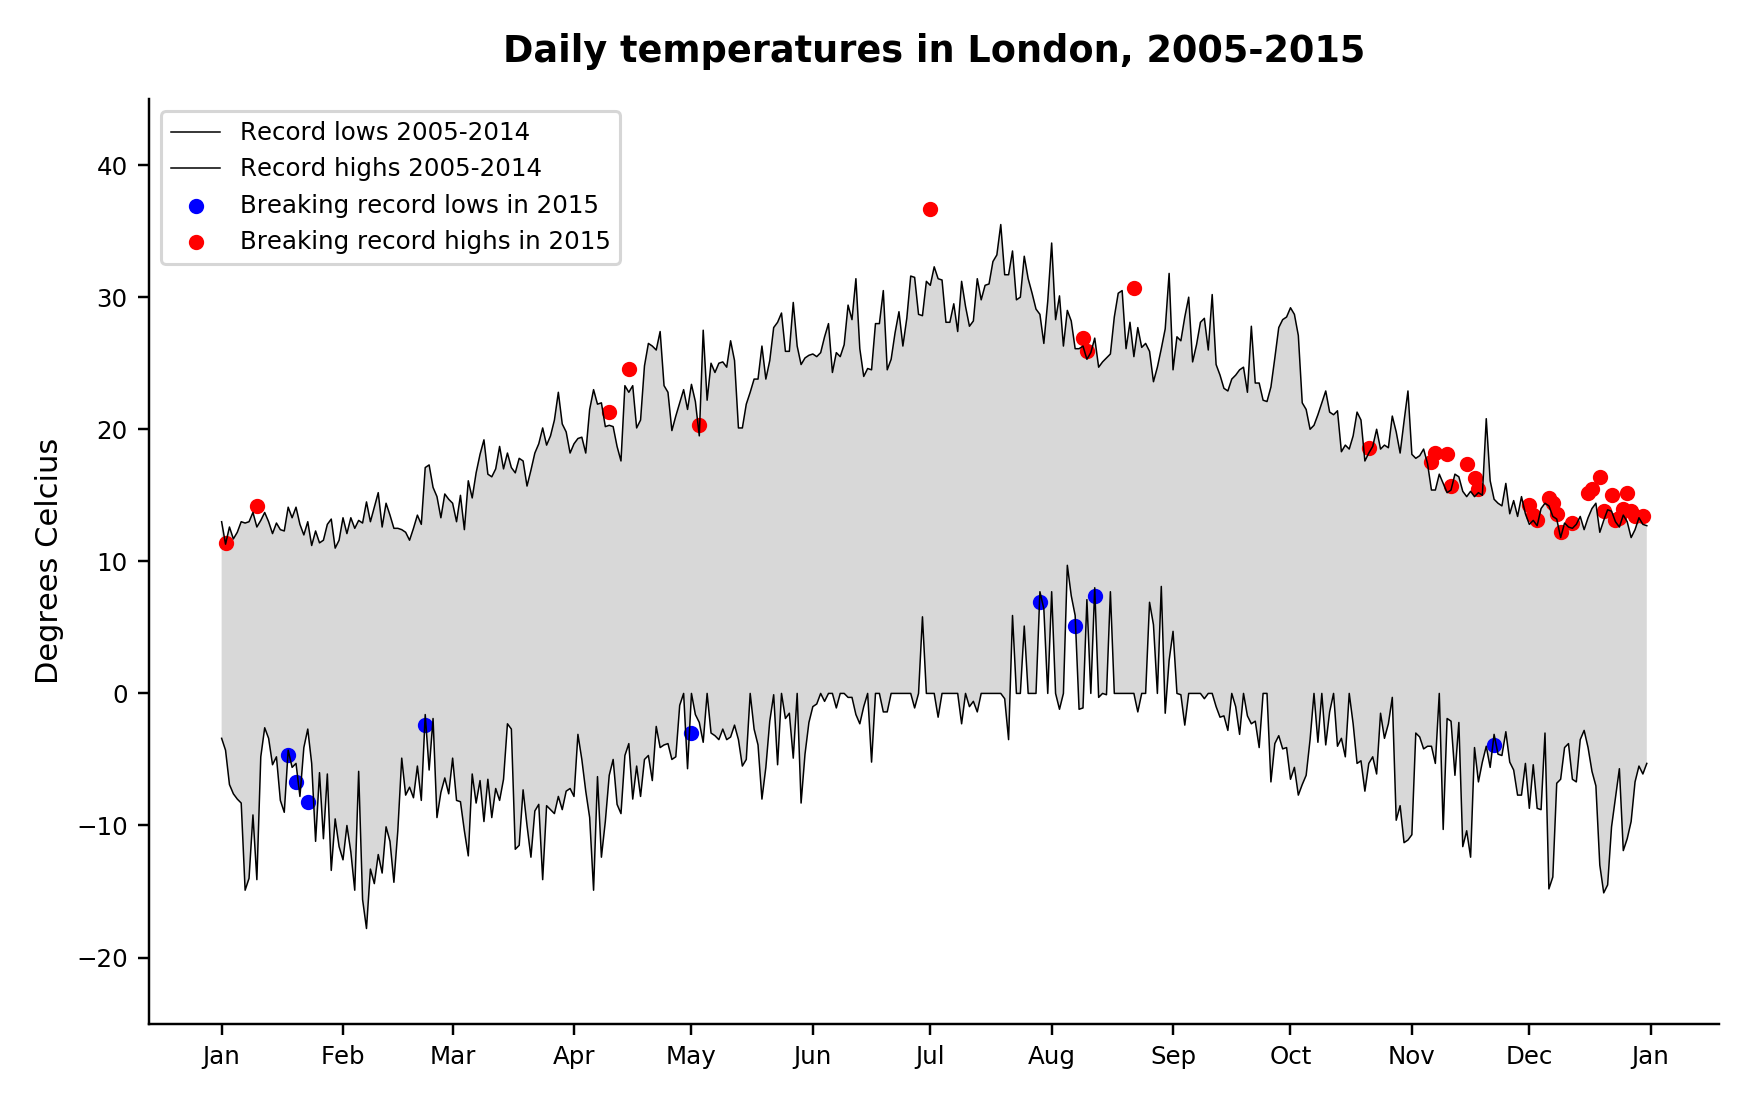

In [15]:
# Set params for the plot

plt.rcParams['lines.markersize'] = 4

# Create a plot

fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111)

# Plot record lows & highs 2005-2014

ax.plot_date(record_temp_df.index, 
             list(record_temp_df['MIN']), 
             '-', color='k', 
             linewidth=0.5, 
             label='Record lows 2005-2014')

ax.plot_date(record_temp_df.index, 
             list(record_temp_df['MAX']), 
             '-', 
             color='k', 
             linewidth=0.5, 
             label='Record highs 2005-2014')

# Fill the gap between

ax.fill_between(record_temp_df.index, 
                record_temp_df['MIN'], 
                record_temp_df['MAX'], 
                facecolor='grey', 
                alpha=0.3)

In [16]:
# Plot the breaking lows and highs from 2015 datapoints

ax.scatter(merged_df.index, 
           merged_df['2015_min'], 
           color='b', 
           label='Breaking record lows in 2015')

ax.scatter(merged_df.index, 
           merged_df['2015_max'], 
           color='r', 
           label='Breaking record highs in 2015')

In [17]:
# Format x axis to display only months

from matplotlib.dates import MonthLocator, DateFormatter

months = MonthLocator(range(1, 13))
monthsFmt = DateFormatter('%b')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)

In [18]:
# Format title

ax.set_title('Daily temperatures in London, 2005-2015', 
             fontsize=12, 
             fontweight='bold')

ttl = ax.title
ttl.set_position([.5, 1.02])

# Format y axis

ax.set_ylim(-25, 45)
ax.set_ylabel('Degrees Celcius')

# Format labels

ax.tick_params(axis='both', which='major', labelsize=8)

# Add legend

ax.legend(loc='upper left', fontsize=8)

# Remove unnecessary frames

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Save an image

plt.tight_layout()
plt.savefig('./daily-temps-london-2005-2015.png',
            bbox_inches='tight',
            dpi=300)